Import the module with all the funcions definitions

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import analisys_module as am
dir(am)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__warningregistry__',
 'compute_B2',
 'curve_fit',
 'integrate',
 'lin_regress',
 'lj',
 'logx_grid',
 'np',
 'plot_EOS',
 'plt',
 'read_data',
 'sw',
 'virial_coefficient',
 'virial_coefficient_lj',
 'virial_coefficient_sw',
 'virial_coefficient_vdw',
 'write_data']

Let's plot the Equation Of State for a random temperature and look at the linear fit

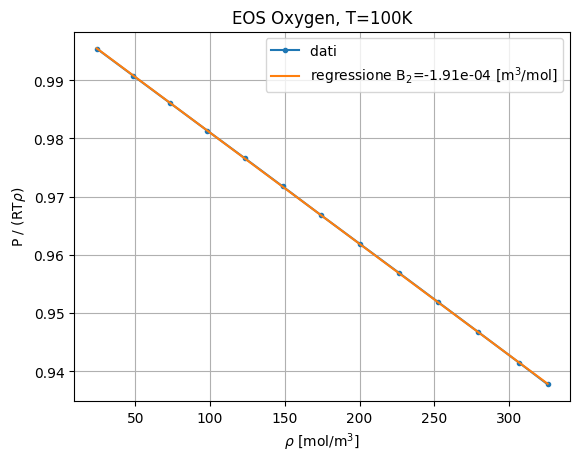

In [142]:
temperature = 100

filename = 'data_T' + str(temperature) + '.txt'
filepath = './data/'
filename = filepath + filename

data = am.read_data(filename=filename)
T = data[:,0]
P = data[:,1]
d = data[:,2]
red_P = P/8.314/T/d*1e6

am.plot_EOS(X=d,Y=red_P,ttl='EOS Oxygen, T=' + str(temperature) + 'K',grade=1)

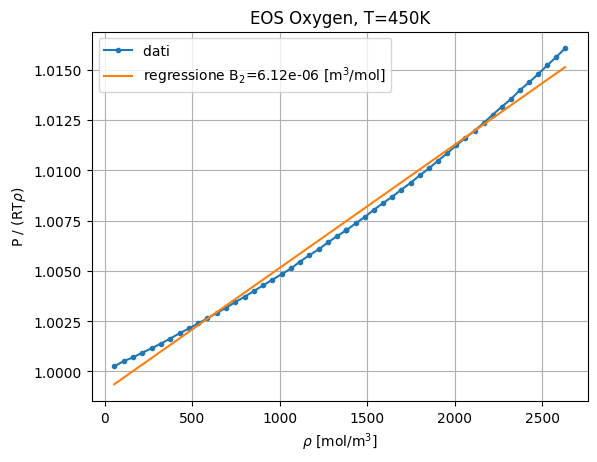

In [143]:
temperature = 450

filename = 'data_T' + str(temperature) + '.txt'
filepath = './data/'
filename = filepath + filename

data = am.read_data(filename=filename)
T = data[:,0]
P = data[:,1]
d = data[:,2]
red_P = P/8.314/T/d*1e6

am.plot_EOS(X=d,Y=red_P,ttl='EOS Oxygen, T=' + str(temperature) + 'K',grade=1)

Come possiamo vedere qua sopra, un fit lineare non basta.  
Aumentiamo il grado del polinomio a 3 così da fittare bene solo i primi termini lineari:

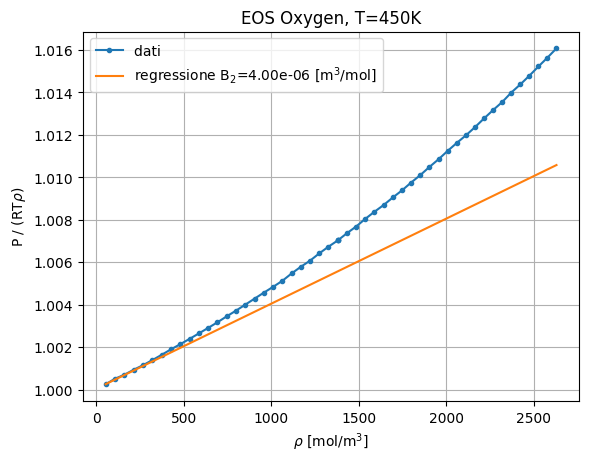

In [144]:
am.plot_EOS(X=d,Y=red_P,ttl='EOS Oxygen, T=' + str(temperature) + 'K',grade=3)

Facciamo ora un plot osservando $B_2$ in funzione della temperatura.

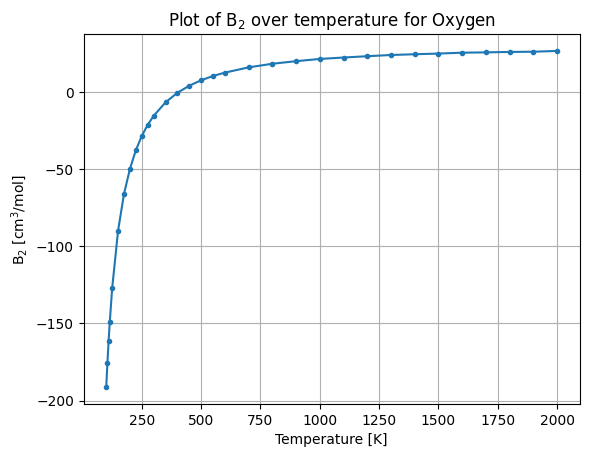

In [145]:
T_Oxygen = [100, 105, 110, 115, 125, 150, 175, 200, 225, 250, 275, 300, 350, 400, 450, 
                500, 550, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 
                1500, 1600, 1700, 1800, 1900, 2000]

m3_to_cm3 = 1e6  # conversione di B2 da m^3/mol a cm^3/mol

data_B2_Oxygen = np.ndarray((np.size(T_Oxygen),2))
for i in range(np.size(T_Oxygen)):
    data_B2_Oxygen[i,0] = T_Oxygen[i]
    data_B2_Oxygen[i,1] = (am.compute_B2(temperature=T_Oxygen[i],grade=3) * m3_to_cm3)

am.write_data(filename="B2_Oxygen.txt",data=data_B2_Oxygen)

plt.plot(T_Oxygen,data_B2_Oxygen[:,1],'.-')
plt.xlabel("Temperature [K]")
plt.ylabel(r'B$_2$ [cm$^3$/mol]')
plt.title(r'Plot of B$_2$ over temperature for Oxygen')
plt.grid()

Facciamo adesso un fit per trovarci i coefficienti $\sigma$ e $\epsilon$ per il potenziale di Lennard-Jones (_LJ_), $\sigma$, $\epsilon$ e $R$ per il potenziale di square well (_SW_) e $a$ e $b$ per il potenziale di van der Waals (_vdW_).

In [146]:
data_B2_Oxygen[:,1] = data_B2_Oxygen[:,1] * (10/6)  # Convert B2 from cm^3/mol to A^3

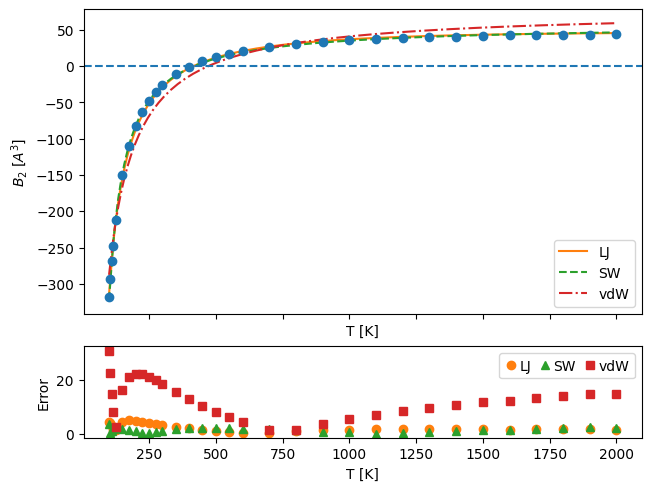

In [147]:
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(2, 1, sharex=True, layout='constrained', height_ratios=(1, 0.3))

# Main figure
Ts = np.array(am.logx_grid(data_B2_Oxygen[0,0], data_B2_Oxygen[-1,0], 40))
popt_lj, pcov = curve_fit(am.virial_coefficient_lj, data_B2_Oxygen[:,0], data_B2_Oxygen[:,1], p0=(100, 1))
popt_sw, pcov = curve_fit(am.virial_coefficient_sw, data_B2_Oxygen[:,0], data_B2_Oxygen[:,1], p0=(100, 1, 2))
popt_vdw, pcov = curve_fit(am.virial_coefficient_vdw, data_B2_Oxygen[:,0], data_B2_Oxygen[:,1], p0=(100, 1))
ax = axs[0]
ax.plot(Ts, am.virial_coefficient_lj(Ts, *popt_lj), '-', color='C1', label='LJ')
ax.plot(Ts, am.virial_coefficient_sw(Ts, *popt_sw), '--', color='C2', label='SW')
ax.plot(Ts, am.virial_coefficient_vdw(Ts, *popt_vdw), '-.', color='C3', label='vdW')
ax.plot(data_B2_Oxygen[:,0], data_B2_Oxygen[:,1], 'o', color='C0')
ax.set_xlabel('T [K]')
ax.set_ylabel('$B_2$ [$A^3$]')
ax.legend()
ax.axhline(0, ls='dashed')

# Error on lower panel
ax = axs[1]
ax.plot(data_B2_Oxygen[:,0], np.abs(am.virial_coefficient_lj(data_B2_Oxygen[:,0], *popt_lj)-data_B2_Oxygen[:,1]), 'o', color='C1', label='LJ')
ax.plot(data_B2_Oxygen[:,0], np.abs(am.virial_coefficient_sw(data_B2_Oxygen[:,0], *popt_sw)-data_B2_Oxygen[:,1]), '^', color='C2', label='SW')
ax.plot(data_B2_Oxygen[:,0], np.abs(am.virial_coefficient_vdw(data_B2_Oxygen[:,0], *popt_vdw)-data_B2_Oxygen[:,1]), 's', color='C3', label='vdW')
ax.set_xlabel('T [K]')
ax.set_ylabel('Error')
ax.legend(ncols=3, handlelength=1, handletextpad=0.1, columnspacing=0.5)

# fig.savefig('./_static/Oxygen_error.svg')
fig.show()

Let's save the fitted parameters in different files:

In [ ]:
# popt_lj[0]
filename_lj = "./B2_Oxygen_LJ.yaml"
filename_sw = "./B2_Oxygen_SW.yaml"
filename_vdw = "./B2_Oxygen_vdW.yaml"

with open(filename_lj, "w") as f:
    f.write(f"epsilon: {popt_lj[0]:.4} K\n")
    f.write(f"sigma: {popt_lj[1]:.3} A\n")
    f.write(f"model: LJ\n")
    f.write(f"system: Oxygen\n")

with open(filename_sw, "w") as f:
    f.write(f"epsilon: {popt_sw[0]:.4} K\n")
    f.write(f"sigma: {popt_sw[1]:.3} A\n")
    f.write(f"R: {popt_sw[2]:.3} A\n")
    f.write(f"model: SW\n")
    f.write(f"system: Oxygen\n")

with open(filename_vdw, "w") as f:
    f.write(f"a: {popt_vdw[0]:.5}\n")
    f.write(f"b: {popt_vdw[1]:.3} A^3\n")
    f.write(f"model: vdW\n")
    f.write(f"system: Oxygen\n")

The final parameters are:

**Lennard-Jones**

- $\epsilon/k_B$ = 121.9 K

- $\sigma$ = 3.48 A

**Square-well**

- $\epsilon/k_B$ = 109.3 K

- $\sigma$ = 3.01 A

- $R$ = 1.63 A

**van der Waals**

- $a$ = 36499

- $b$ = 77.3 $A^3$